In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# odszumianie sygnału

df = pd.read_csv('../../data/partially processed/resampled_data_no_outliers.csv')
df.drop(columns=['outlier_label'], inplace=True)
df['epoch (ms)'] = pd.to_datetime(df['epoch (ms)'])
df.set_index('epoch (ms)', inplace=True)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)



# calate set duration
for i in df["set"].unique():
    duration = df[df["set"] == i].index[-1] - df[df["set"] == i].index[0]
    df.loc[df["set"] == i, "duration"] = duration.seconds
    
duration_data = df.groupby("category")["duration"].mean()
    




In [2]:
duration_data

category
heavy       14.696778
medium      24.806720
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [2]:
df_filtered = df.copy()
columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

for cat, duration in duration_data.items():
    subset = df_filtered[df_filtered["category"] == cat]
    if len(subset) == 0:
        continue
    if cat == "heavy":
        fs = len(subset) / (duration/5)
    if cat == "medium":
        fs = len(subset) / (duration/10)
    
    cutoff = fs / 5.0
    for col in columns_to_check:
        filtered = butter_lowpass_filter(subset[col].values, cutoff, fs)
        df_filtered.loc[subset.index, col] = filtered


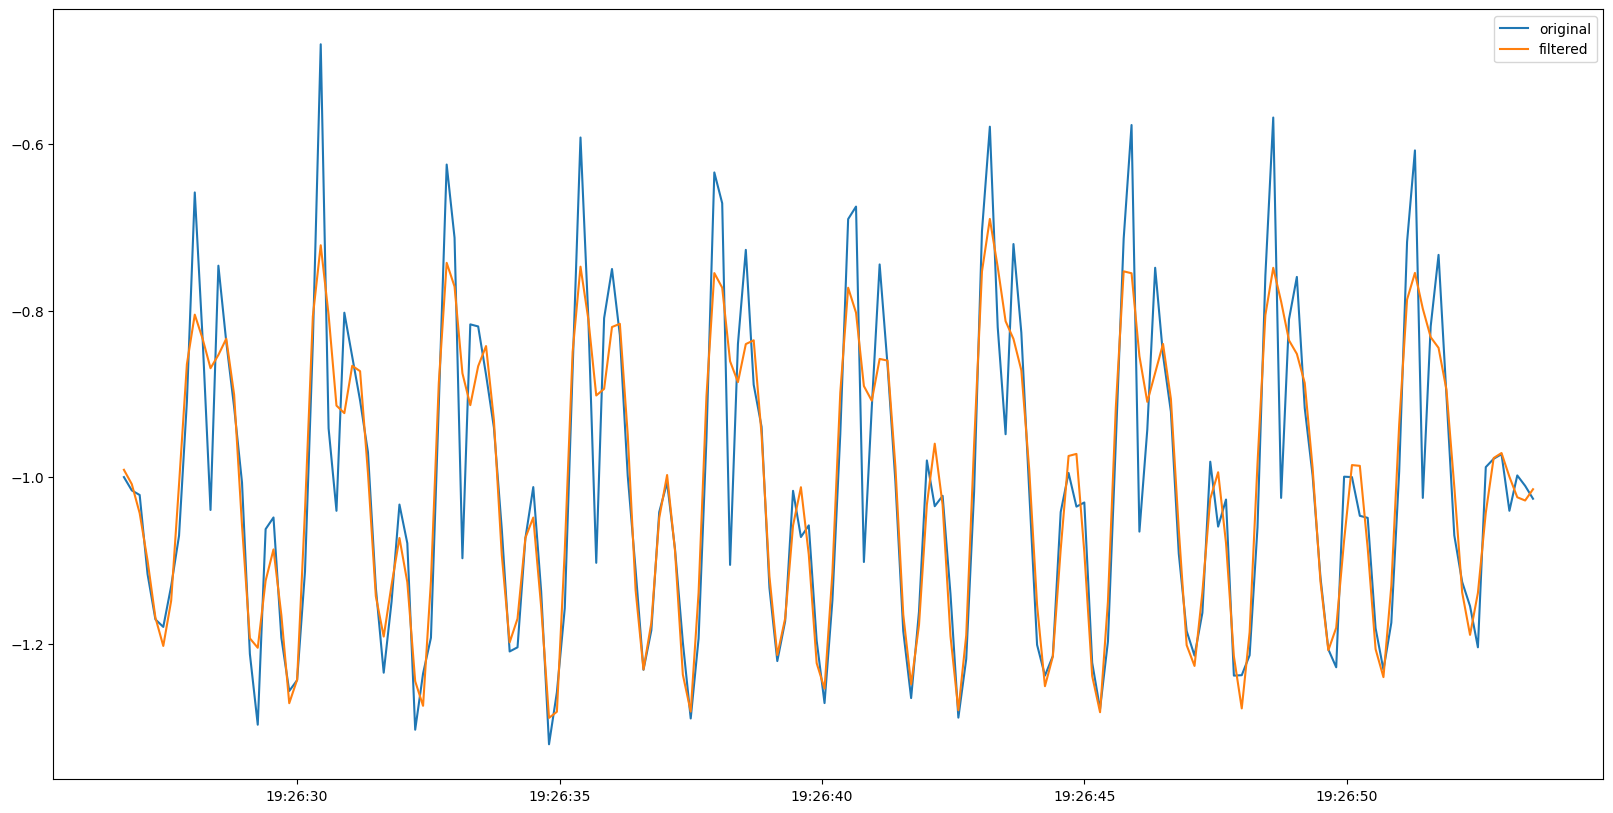

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

osdf = df[df["set"] == 20]
fsdf = df_filtered[df_filtered["set"] == 20]

plt.figure(figsize=(20, 10))
plt.plot(osdf["acc_y"], label="original")
plt.plot(fsdf["acc_y"], label="filtered")
plt.legend()
plt.show()




In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the data
X = df[columns_to_check]
y = df['label']

X_filtered = df_filtered[columns_to_check]
y_filtered = df_filtered['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

# Train the Random Forest classifier on the original data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Train the Random Forest classifier on the filtered data
clf_filtered = RandomForestClassifier(n_estimators=100, random_state=42)
clf_filtered.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_filtered = clf_filtered.predict(X_test_filtered)

# Print classification reports
print("Classification report for original data:")
print(classification_report(y_test, y_pred))

print("Classification report for filtered data:")
print(classification_report(y_test_filtered, y_pred_filtered))

Classification report for original data:
              precision    recall  f1-score   support

       bench       0.93      0.91      0.92       652
        dead       0.96      0.96      0.96       631
         ohp       0.92      0.93      0.93       683
        rest       1.00      1.00      1.00       426
         row       0.95      0.96      0.95       552
       squat       0.99      1.00      1.00       645

    accuracy                           0.96      3589
   macro avg       0.96      0.96      0.96      3589
weighted avg       0.96      0.96      0.96      3589

Classification report for filtered data:
              precision    recall  f1-score   support

       bench       0.93      0.93      0.93       652
        dead       0.97      0.96      0.97       631
         ohp       0.93      0.94      0.93       683
        rest       0.99      1.00      1.00       426
         row       0.96      0.97      0.96       552
       squat       1.00      1.00      1.00       

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# odszumianie sygnału

df = pd.read_csv('../../data/partially processed/resampled_data_no_outliers.csv')
df.drop(columns=['outlier_label'], inplace=True)
df['epoch (ms)'] = pd.to_datetime(df['epoch (ms)'])
df.set_index('epoch (ms)', inplace=True)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)



def calculate_set_duration(df):
    for i in df["set"].unique():
        duration = df[df["set"] == i].index[-1] - df[df["set"] == i].index[0]
        df.loc[df["set"] == i, "duration"] = duration.seconds
    
    duration_data = df.groupby("category")["duration"].mean()
    return duration_data

def apply_low_pass_filter(df, duration_data):
    df_filtered = df.copy()
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

    for cat, duration in duration_data.items():
        subset = df_filtered[df_filtered["category"] == cat]
        if len(subset) == 0:
            continue
        if cat == "heavy":
            fs = len(subset) / (duration / 5)
        if cat == "medium":
            fs = len(subset) / (duration / 10)

        cutoff = fs / 5.0
        for col in columns_to_check:
            filtered = butter_lowpass_filter(subset[col].values, cutoff, fs)
            df_filtered.loc[subset.index, col] = filtered

    return df_filtered

# Example usage:
duration_data = calculate_set_duration(df)
df_filtered = apply_low_pass_filter(df, duration_data)

    




Explained Variance Ratio: [0.40552206 0.22240563 0.17203541]


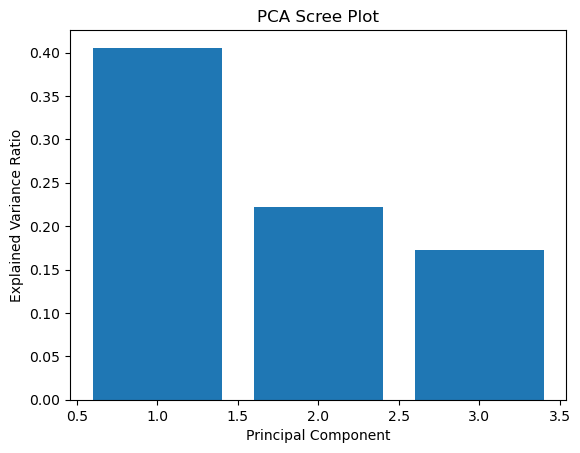

        PC1       PC2       PC3
0  0.272332 -1.340404 -0.082397
1  0.363267 -1.306911 -0.018164
2  0.495951 -1.173534  0.019471
3  0.524245 -0.963951 -0.025554
4  0.356000 -0.800137 -0.165233


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# filepath: /Users/stanislaw/Docs/inzynierka/inzynierka/data/partially processed/filtered_data_sample.csv
df = pd.read_csv("/Users/stanislaw/Docs/inzynierka/inzynierka/data/partially processed/filtered_data_sample.csv")

# Select numeric columns for PCA
numeric_cols = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
X = df[numeric_cols].values

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance
# print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# # Optional: plot explained variance
# plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('PCA Scree Plot')
# plt.show()

# PCA-transformed DataFrame with 3 principal components
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(3)])
print(df_pca.head())
df_pca.to_csv("/Users/stanislaw/Docs/inzynierka/inzynierka/data/partially processed/pca_transformed_data.csv", index=False)